In [1]:
import numpy as np
import scanpy as sc
import scvelo as scv
import torch
from umap import UMAP
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu

from deepvelo.utils import (
    velocity,
    velocity_confidence,
    continuity_confidence,
    update_dict,
    cross_boundary_correctness,
)
from deepvelo.utils.scatter import scatter
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants

Using backend: pytorch
/home/tung/anaconda3/envs/deepvelo/lib/python3.8/site-packages/deepvelo/utils/scatter.py:5: DeprecationWarning: deepvelo.utils.scatter is deprecated. Please use deepvelo.plot.scatter instead.
  warnings.warn(
/home/tung/anaconda3/envs/deepvelo/lib/python3.8/site-packages/deepvelo/utils/plot.py:5: DeprecationWarning: deepvelo.utils.plot is deprecated. Please use deepvelo.plot.plot instead.
  warnings.warn(


In [2]:
adata = scv.read("adata_postpro.h5ad")

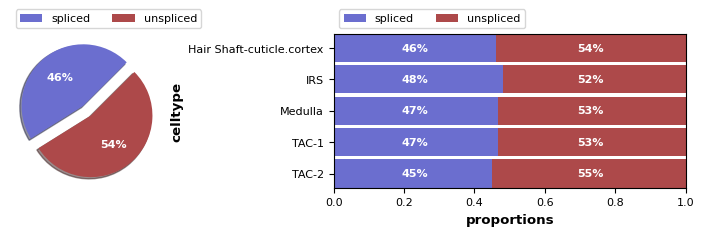

In [3]:
scv.pl.proportions(adata, groupby = "celltype")

In [4]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
}
configs = update_dict(Constants.default_configs, configs)

The ratio of spliced reads is 46.4% (less than 70%). Suggest using coeff_s 0.5.


In [5]:
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [6]:
velocity(adata, mask_zero=False)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [7]:
trainer = train(adata, configs)

Config Warning: Set to use GPU, but GPU version of DGL is not installed. Reset to use CPU instead.
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([6436, 962])
confidence mse shape: (6436, 962)
confidence mse stats: max 63.893760681152344, min 0.0, mean 0.013261059299111366, std 0.15394620597362518
confidence corr shape: (962,)
confidence corr stats: max 0.8161914348602295, min -0.01281698513776064, mean 0.6254878640174866, std 0.11646895110607147
velo_mat shape: (6436, 962)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


In [8]:
scv.tl.velocity_graph(adata, n_jobs=8)

computing velocity graph (using 8/24 cores)


  0%|          | 0/6436 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


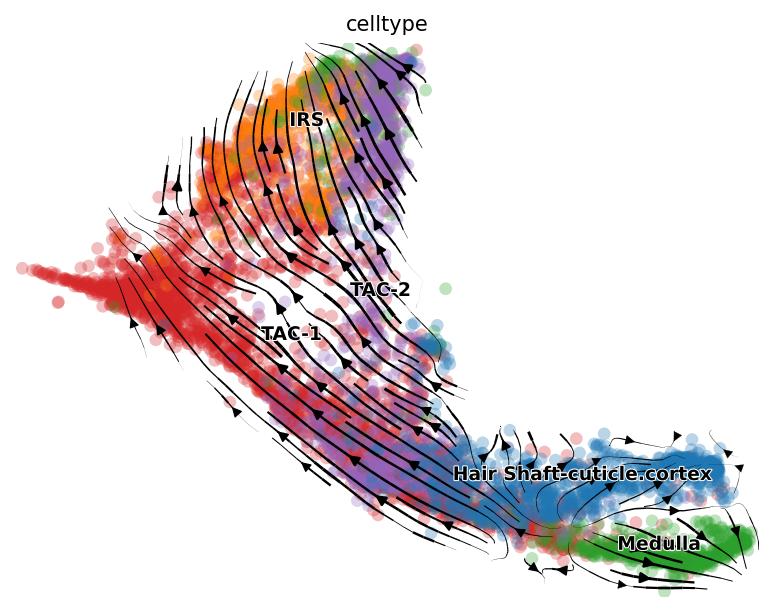

In [9]:
scv.pl.velocity_embedding_stream(
    adata,
    basis="umap",
    color="celltype",
    legend_fontsize=9,
    dpi=150            # increase dpi for higher resolution
)

In [10]:
scv.tl.velocity_pseudotime(adata)

computing terminal states
    identified 4 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [11]:
adata.write_h5ad("data/deepvelo.h5ad")